# SynthStrip tutorial
[SynthStrip](https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/) is a skull-stripping tool that works with many different image types and modalities, including MRI, DWI, CT, PET, etc.

If you use the SynthStrip, please cite SynthStrip:

> SynthStrip: Skull-Stripping for Any Brain Image
Andrew Hoopes, Jocelyn S. Mora, Adrian V. Dalca, Bruce Fischl*, Malte Hoffmann* (*equal contribution)
NeuroImage 260, 2022, 119474
https://doi.org/10.1016/j.neuroimage.2022.119474

> Boosting skull-stripping performance for pediatric brain images
William Kelley, Nathan Ngo, Adrian V. Dalca, Bruce Fischl, Lilla Zöllei*, Malte Hoffmann* (*equal contribution)
IEEE International Symposium on Biomedical Imaging (ISBI), 2024, forthcoming
https://arxiv.org/abs/2402.16634

### Installation
Installation instructions are available at https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/, navigate to the "SynthStrip Tool" section.

You will need the "mri_synthstrip" python script, if you have FreeSurfer installed, it should be included. 

If you do not want to install FreeSurfer, the tool can also be ran in a Docker/Singularity container. If you are on Linux, it is easy to set up. The page provides two scripts that automatically set up a Docker or Singularity container for you (make sure you have Docker/Signalarity installed). You can download the scripts by pasting a command starting with `curl -O https://...`, this will download a python script to the current directory.

### Usage
Please read the instructions at the top of the downloaded script. The script can be used from terminal. If you aren't using FreeSurfer, first time you run it, it will set up the Docker/Singularity container.

mrid provides an API for synthstrip in `mrid.synthstrip` subpackage, as well as `study.skullstrip_synthstrip`, method on `mrid.Study`. You will need to pass path to the synthstrip script to those functions.

#### Data
For this example we download some MRIs from https://zenodo.org/records/7213153 in DICOM format.

Colin Vanden Bulcke. (2022). Open-Access DICOM MRI session (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7213153

In [1]:
# note that since the download is large, this script may fail or download corrupted ZIP. 
# In this case you can try downloading it manually from your browser or use any other MRIs you have.

import os, shutil, requests
from pathlib import Path

if "BMAT_MRI_session" not in os.listdir("data"):

    # download
    if "BMAT_MRI_session.zip" not in os.listdir("data"):
        response = requests.get("https://zenodo.org/records/7213153/files/BMAT_MRI_session.zip?download=1", stream=True)
        response.raise_for_status()
        with open("data/BMAT_MRI_session.zip", 'wb') as file:
            shutil.copyfileobj(response.raw, file) # type:ignore

    # unpack
    shutil.unpack_archive("data/BMAT_MRI_session.zip", "data")

ROOT = Path("data/BMAT_MRI_session/export/home1/sdc_image_pool/images/p883/e1007")
os.listdir(ROOT)

['s16342',
 's16335',
 's16343',
 's16329',
 's16341',
 's16340',
 's16336',
 's16337',
 's16328',
 's16330']

#### Skullstripping one image

Skullstripping one image can be performed via `mrid.synthstrip.skullstrip` function. You will need to pass path to the SynthStrip script to it (see **Installation** section above).

The scans you pass can be path to a .nii.gz file, DICOM directory, sitk.Image, numpy array or torch tensor. All functions return ``sitk.Image``.

Running SynthStrip version 1.8 from Docker
Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: /tmp/tmp86tusz2x/image.nii.gz
Processing frame (of 1): 1 done
Binary brain mask saved to: /tmp/tmp86tusz2x/synthstrip_mask.nii.gz

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474

Website: https://synthstrip.io



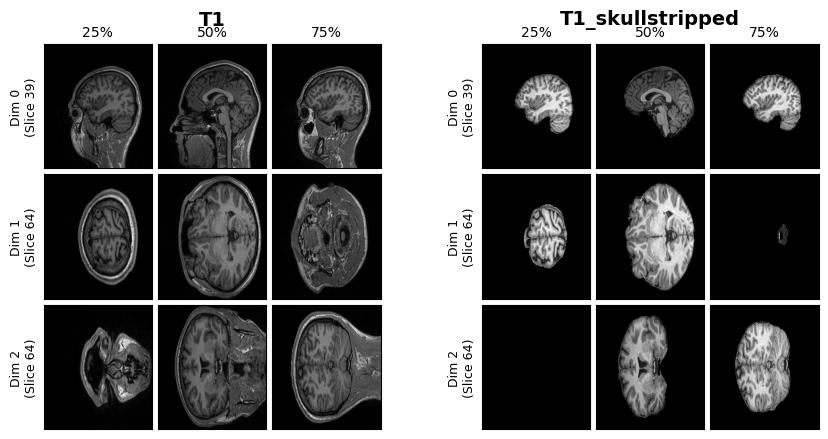

In [2]:
import mrid

# replace this with your path to synthstrip script
SYNTHSTRIP_SCRIPT_FILE = "/var/mnt/issd/files 2/programming/libs/synthstrip/synthstrip-docker"
assert os.path.isfile(SYNTHSTRIP_SCRIPT_FILE), "SYNTHSTRIP_PATH should point to a file"

T1 = ROOT / "s16329"
T1_skullstripped = mrid.synthstrip.skullstrip(SYNTHSTRIP_SCRIPT_FILE, image=T1) # sitk.Image

mrid.utils.plot_study({"T1": T1, "T1_skullstripped": T1_skullstripped})

#### Getting the brain mask
If you just need the brain mask, use `mrid.synthstrip.predict_brain_mask`.

Running SynthStrip version 1.8 from Docker
Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: /tmp/tmp9zdp9o6p/image.nii.gz
Processing frame (of 1): 1 done
Binary brain mask saved to: /tmp/tmp9zdp9o6p/synthstrip_mask.nii.gz

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474

Website: https://synthstrip.io



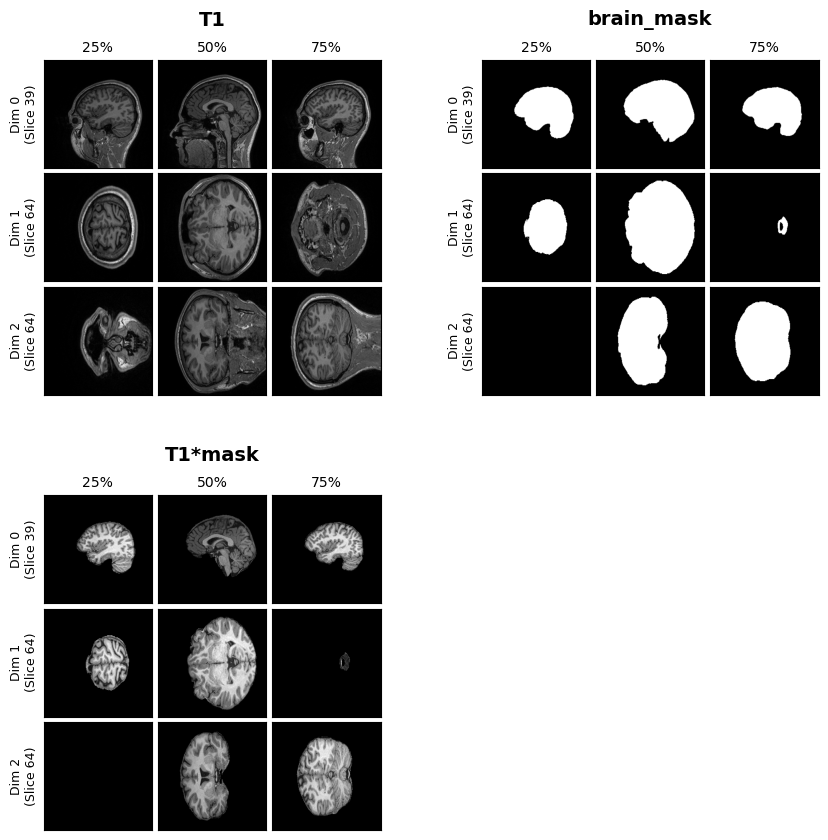

In [3]:
brain_mask = mrid.synthstrip.predict_brain_mask(SYNTHSTRIP_SCRIPT_FILE, image=T1) # sitk.Image

mrid.utils.plot_study({"T1": T1, "brain_mask": brain_mask, "T1*mask": mrid.mask.apply_mask(T1, brain_mask)})

#### Skullstripping multiple modalities
If you have multiple aligned modalities, you can predict brain mask on the most high-resolution one and apply it to all modalities. In this case all modalities must be aligned. Since in the sample dataset modalities are not aligned, we will first align them using SimpleElastix. Then we can use `mrid.synthstrip.skullstrip_D` function to predict brain mask on one modality and apply it to all modalities.

`mrid.synthstrip.skullstrip_D` returns a new dictionary with the same keys as input dictionary, but all values are skull-stripped `sitk.Image`. 

if you pass `keep_original=True`, it keeps original images before skull-stripping, and add skull-stripped scans with `_synthstrip` postfix. 

You can also pass `include_mask` to add a `seg_synthstrip` key with the predicted brain mask.

Running SynthStrip version 1.8 from Docker
Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: /tmp/tmp14tgsur3/image.nii.gz
Processing frame (of 1): 1 done
Binary brain mask saved to: /tmp/tmp14tgsur3/synthstrip_mask.nii.gz

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474

Website: https://synthstrip.io

data_skullstripped = {'T1': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fb3d3e3f420> >, 'FLAIR': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fb3d3f49620> >}


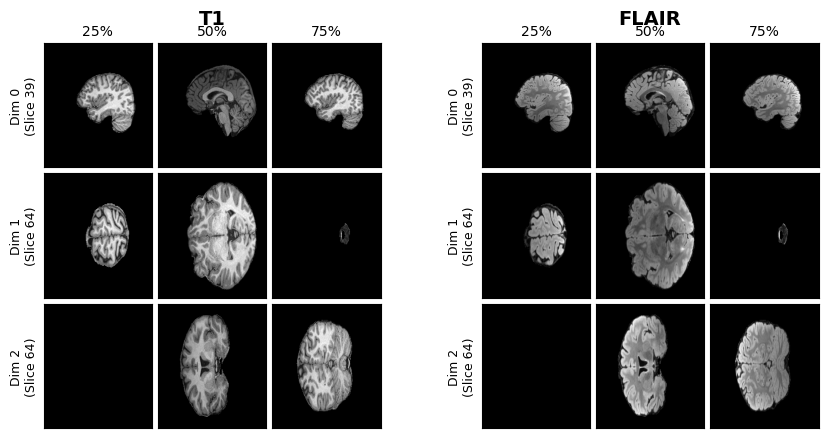

In [4]:
data = {
    "T1": ROOT / "s16329",
    "FLAIR": ROOT/"s16340",
}

# T1 and FLAIR scans are not aligned (they have different sizes).
# We have to first align them to some common space. For example, we can align FLAIR to T1
# using `mrid.simple_elastix.register_each`.
data_aligned = mrid.simple_elastix.register_each(data, key="T1")

# pass data["T1"] to synthstrip
data_skullstripped = mrid.synthstrip.skullstrip_D(SYNTHSTRIP_SCRIPT_FILE, images=data_aligned, key="T1") 

print(f"{data_skullstripped = }")
mrid.utils.plot_study(data_skullstripped)

### Study interace

`study.skullstrip_synthstrip` is essentially the same as `mrid.synthstrip.skullstrip_D`. 

It does not affect segmentations (keys starting with `"seg"`). 

Running SynthStrip version 1.8 from Docker
Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: /tmp/tmpcvvctoc5/image.nii.gz
Processing frame (of 1): 1 done
Binary brain mask saved to: /tmp/tmpcvvctoc5/synthstrip_mask.nii.gz

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474

Website: https://synthstrip.io

study_skullstripped = {'seg_synthstrip': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fb3d4228900> >, 'T1': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fb51a662b80> >, 'FLAIR': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fb3d3b186c0> >}


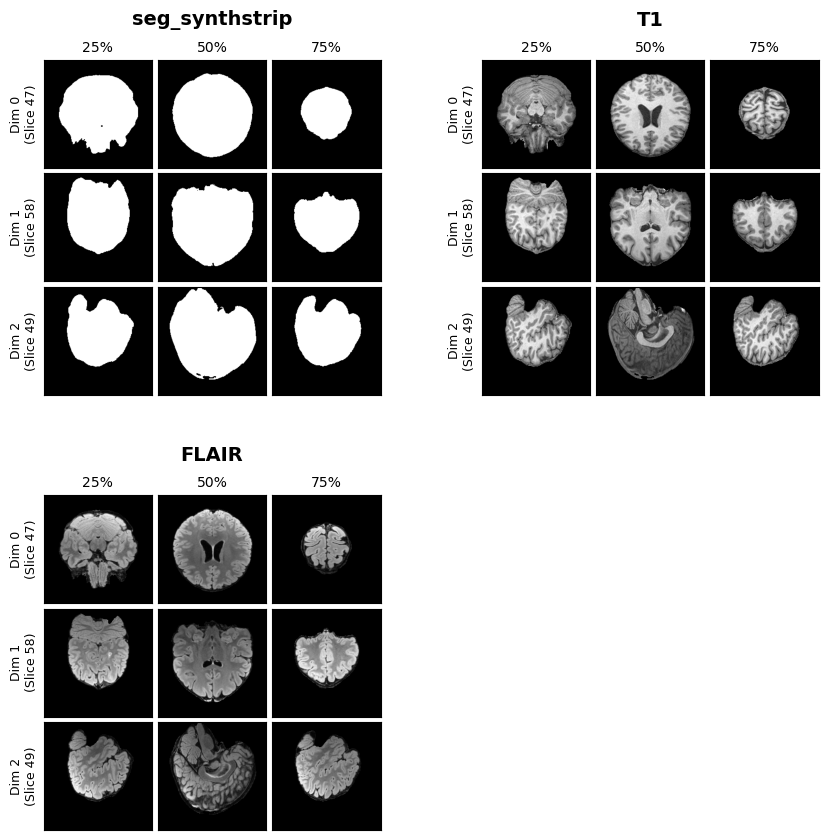

In [6]:
study = mrid.Study(T1 = ROOT / "s16329", FLAIR = ROOT/"s16340")

# this time we will align both scans to MNI152, you can compare results to HD-BET notebook
study_mni152 = study.register_each_SE(key="T1", to=mrid.get_mni152("2009a T1w asymmetric"))

# pass T1 to synthstrip
study_skullstripped = study_mni152.skullstrip_synthstrip(SYNTHSTRIP_SCRIPT_FILE, key="T1", include_mask=True)

print(f"{study_skullstripped = }")
study_skullstripped.plot()